<a href="https://colab.research.google.com/github/dsiervo/topnews/blob/master/Others_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install simpletransformers
!pip install simpletransformers
!pip install ktrain

     |████████████████████████████████| 102kB 6.1MB/s 
     |████████████████████████████████| 450kB 14.4MB/s 
     |████████████████████████████████| 204kB 21.5MB/s 
     |████████████████████████████████| 1.0MB 24.3MB/s 
     |████████████████████████████████| 860kB 55.4MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=5c95946c2831c91c4bf68ffa7179c5d2b1bc1293c94fd46a2f10de12065cd02b
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for sacremoses: filename=sacremoses-0.0.35-cp36-none-any.whl size=883999 sha256=da5a4f4eb0748e085e14bb4d49bf4e1dde0d150993b028a25509009299a128ce
  Stored in directory: /root/.cache/pip/wheels/63/2a/db/63e2909042c634ef551d0d9ac825b2b0b32dede4a6d87ddc94
Successfully built seqeval sacremoses
     |████████████████████████████████| 92kB 5.9MB/s 
     |████████████████████████████████| 1.0MB 11.3MB/s 
     |████████████████████████████████| 245kB

In [2]:
from simpletransformers.classification import ClassificationModel
import tensorflow as tf
import pandas as pd
import ktrain
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
from plotly.offline import init_notebook_mode,iplot
import plotly.graph_objects as go
import cufflinks as cf
from sklearn.metrics import accuracy_score

using Keras version: 2.2.4-tf


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data exploration and cleaning

In [0]:
path = '/content/drive/My Drive/News_Category_Dataset_v2.json'

df_ = pd.read_json(path, lines=True)

In [5]:
df_['text'] = df_['authors']+' '+df_['headline'] +' '+ df_['short_description']

df = df_.drop(['link', 'date', 'headline', 'short_description', 'authors'], axis=1)

df.head()

,category,text
0,CRIME,Melissa Jeltsen There Were 2 Mass Shootings In...
1,ENTERTAINMENT,Andy McDonald Will Smith Joins Diplo And Nicky...
2,ENTERTAINMENT,Ron Dicker Hugh Grant Marries For The First Ti...
3,ENTERTAINMENT,Ron Dicker Jim Carrey Blasts 'Castrato' Adam S...
4,ENTERTAINMENT,Ron Dicker Julianna Margulies Uses Donald Trum...


In [0]:
cat_count = df['category'].value_counts()

In [0]:
culture = ['ARTS & CULTURE', 'ARTS', 'CULTURE & ARTS']
worldpost = ['WORLDPOST', 'THE WORLDPOST']
parents = ['PARENTING', 'PARENTS']

df['category'][df['category'].isin(culture)] = "CULTURE"
df['category'][df['category'].isin(worldpost)] = "WORLDPOST"
df['category'][df['category'].isin(parents)] = "PARENTS"

In [0]:
cats = df.category.unique()
def cat_to_num(lab):
  return np.where(cats == lab)[0][0]

df['label'] = df['category'].apply(cat_to_num)

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'], df['label'])


## Feature engineering and downloading pretrained NBSVM model


In [0]:
(x_train, y_train), (x_test, y_test), preproc = ktrain.text.texts_from_array(
                                                            x_train=X_train.to_list(), y_train=Y_train.to_list(),
                                                            x_test=X_test.to_list(), y_test=Y_test.to_list(),
                                                            class_names=list(cats),
                                                            maxlen=350, 
                                                            max_features=35000)

language: en
Word Counts: 117168
Nrows: 150639
150639 train sequences
Average train sequence length: 32
x_train shape: (150639,350)
y_train shape: (150639,37)
50214 test sequences
Average test sequence length: 32
x_test shape: (50214,350)
y_test shape: (50214,37)


## Model creation and training

In [0]:
tf.device('/device:GPU:0')
model = ktrain.text.text_classifier('nbsvm', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), batch_size=6,
                             workers=-1, use_multiprocessing = True)

Is Multi-Label? False
compiling word ID features...
maxlen is 350
building document-term matrix... this may take a few moments...
rows: 1-10000
rows: 10001-20000
rows: 20001-30000
rows: 30001-40000
rows: 40001-50000
rows: 50001-60000
rows: 60001-70000
rows: 70001-80000
rows: 80001-90000
rows: 90001-100000
rows: 100001-110000
rows: 110001-120000
rows: 120001-130000
rows: 130001-140000
rows: 140001-150000
rows: 150001-150639
computing log-count ratios...
done.


In [0]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 150639 samples
Epoch 1/1024
  9366/150639 [>.............................] - ETA: 1:26 - loss: 3.1787 - acc: 0.3655

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


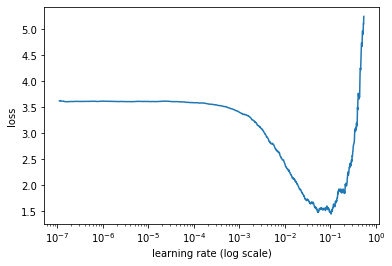

In [0]:
learner.lr_plot()

In [0]:
learner.autofit(0.001, 3)



begin training using triangular learning rate policy with max lr of 0.001...
Train on 150639 samples
Epoch 1/3
150639/150639 [==============================] - 124s 822us/sample - loss: 1.3549 - acc: 0.7081
Epoch 2/3
150639/150639 [==============================] - 123s 818us/sample - loss: 0.8560 - acc: 0.7711
Epoch 3/3
150639/150639 [==============================] - 123s 818us/sample - loss: 0.8053 - acc: 0.7839


In [0]:
learner.validate(val_data=(x_test, y_test), class_names=list(cats))

                precision    recall  f1-score   support

         CRIME       0.54      0.70      0.61       814
 ENTERTAINMENT       0.85      0.74      0.79      3993
    WORLD NEWS       0.31      0.54      0.39       510
        IMPACT       0.54      0.46      0.49       853
      POLITICS       0.88      0.80      0.84      8305
    WEIRD NEWS       0.50      0.51      0.51       639
  BLACK VOICES       0.66      0.55      0.60      1163
         WOMEN       0.57      0.46      0.51       854
        COMEDY       0.68      0.66      0.67      1298
  QUEER VOICES       0.87      0.79      0.83      1616
        SPORTS       0.78      0.78      0.78      1253
      BUSINESS       0.70      0.50      0.58      1460
        TRAVEL       0.88      0.83      0.85      2474
         MEDIA       0.52      0.57      0.54       702
          TECH       0.58      0.66      0.62       511
      RELIGION       0.68      0.64      0.66       640
       SCIENCE       0.59      0.68      0.63  

array([[ 573,    3,    9, ...,    0,    3,    9],
       [  32, 2964,   15, ...,    2,    6,   13],
       [   7,    2,  274, ...,    0,    0,    3],
       ...,
       [   0,    8,    0, ..., 1245,    3,   11],
       [   5,    4,    2, ...,    1,  270,    8],
       [   2,    4,    4, ...,    5,    6,  209]])

# fasttext model

In [0]:
model = ktrain.text.text_classifier('fasttext', (x_train, y_train), preproc=preproc)
learner = ktrain.get_learner(model,train_data=(x_train, y_train), batch_size=6,
                             workers=-1, use_multiprocessing = True)

Is Multi-Label? False
compiling word ID features...
maxlen is 350
done.


In [0]:
learner.lr_find()

simulating training for different learning rates... this may take a few moments...
Train on 150639 samples
Epoch 1/1024
 10224/150639 [=>............................] - ETA: 2:17 - loss: 3.7169 - acc: 0.0737

done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


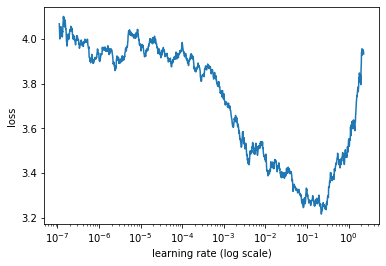

In [0]:
learner.lr_plot()

In [0]:
learner.autofit(0.2, 3)



begin training using triangular learning rate policy with max lr of 0.2...
Train on 150639 samples
Epoch 1/3
150639/150639 [==============================] - 178s 1ms/sample - loss: 3.2628 - acc: 0.1560
Epoch 2/3
150639/150639 [==============================] - 176s 1ms/sample - loss: 3.2616 - acc: 0.1561
Epoch 3/3
150639/150639 [==============================] - 177s 1ms/sample - loss: 3.2614 - acc: 0.1565


In [0]:
learner.validate(val_data=(x_test, y_test), class_names=list(cats))

                precision    recall  f1-score   support

         CRIME       0.00      0.00      0.00       814
 ENTERTAINMENT       0.00      0.00      0.00      3993
    WORLD NEWS       0.00      0.00      0.00       510
        IMPACT       0.00      0.00      0.00       853
      POLITICS       0.17      1.00      0.28      8305
    WEIRD NEWS       0.00      0.00      0.00       639
  BLACK VOICES       0.00      0.00      0.00      1163
         WOMEN       0.00      0.00      0.00       854
        COMEDY       0.00      0.00      0.00      1298
  QUEER VOICES       0.00      0.00      0.00      1616
        SPORTS       0.00      0.00      0.00      1253
      BUSINESS       0.00      0.00      0.00      1460
        TRAVEL       0.00      0.00      0.00      2474
         MEDIA       0.00      0.00      0.00       702
          TECH       0.00      0.00      0.00       511
      RELIGION       0.00      0.00      0.00       640
       SCIENCE       0.00      0.00      0.00  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

# Using simpletransformers

In [0]:
!wget https://repo.anaconda.com/archive/Anaconda3-5.2.0-Linux-x86_64.sh && bash Anaconda3-5.2.0-Linux-x86_64.sh -bfp /usr/local

In [0]:
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages')

In [0]:
!conda install -y -q pytorch cudatoolkit=10.0 -c pytorch

In [13]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [0]:
!sh setup.sh

In [0]:
train = pd.concat([X_train, Y_train], axis=1)
test = pd.concat([X_test, Y_test], axis=1)

In [0]:
train['text'] = train['text'].apply(lambda x: x.replace('\\', ' '))
test['text'] = test['text'].apply(lambda x: x.replace('\\', ' '))

In [0]:
model = ClassificationModel('albert', 'albert-base-v2', num_labels=len(cats),
                            args={'reprocess_input_data': True,
                                  'overwrite_output_dir': True,
                                  'fp16_opt_level': 'O3',
                                  'keep_batchnorm_fp32':True,
                                  "output_dir": "/content/drive/My Drive/NewsBert/outputs/",
                                  "cache_dir": "/content/drive/My Drive/NewsBert/cache_dir/",
                                  "learning_rate": 2e-5,
                                  "num_train_epochs": 3,
                                  'max_seq_length': 300,
                                  'silent': True,
                                  'tensorboard_folder': "/content/drive/My Drive/NewsBert/run/"})

In [0]:
model.train_model(train)

In [0]:
reloaded_model = ClassificationModel('albert', '/content/drive/My Drive/NewsBert/outputs/', num_labels=len(cats),
                            args={'reprocess_input_data': True,
                                  'overwrite_output_dir': True,
                                  "output_dir": "/content/drive/My Drive/NewsBert/outputs/",
                                  "cache_dir": "/content/drive/My Drive/NewsBert/cache_dir/",
                                  "learning_rate": 5e-5,
                                  "num_train_epochs": 1,
                                  'max_seq_length': 300,
                                  'tensorboard_folder': "/content/drive/My Drive/NewsBert/run/"})

In [21]:
result, model_outputs, wrong_predictions = model.eval_model(test, acc=sk.metrics.accuracy_score)

Converting to features started.


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:872: RuntimeWarning:

invalid value encountered in double_scalars



In [0]:
result

In [0]:
train.head()

In [0]:
train.info()